##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Recurrent Neural Networks (RNN) with Keras

## Introduction
## 简介

Recurrent neural networks (RNN) are a class of neural networks that is powerful for
modeling sequence data such as time series or natural language.

循环神经网络（RNN）是一种非常适合序列数据（如时间序列或自然语言）建模的神经网络

Schematically, a RNN layer uses a `for` loop to iterate over the timesteps of a
sequence, while maintaining an internal state that encodes information about the
timesteps it has seen so far.

原理上，RNN层通过for循环迭代序列数据上的时间段，同时保持一个内部状态来编码它所看到的时间段内的信息

The Keras RNN API is designed with a focus on:

- **Ease of use**: the built-in `keras.layers.RNN`, `keras.layers.LSTM`,
`keras.layers.GRU` layers enable you to quickly build recurrent models without
having to make difficult configuration choices.

- **Ease of customization**: You can also define your own RNN cell layer (the inner
part of the `for` loop) with custom behavior, and use it with the generic
`keras.layers.RNN` layer (the `for` loop itself). This allows you to quickly
prototype different research ideas in a flexible way with minimal code.

Keras RNN API聚焦于：

- **易用**: 内置的 `keras.layers.RNN`, `keras.layers.LSTM`,
`keras.layers.GRU` 层可以让你快速地建立循环模型而不用做艰难的设置选择.

- **高度自定义**: 你可以自定义你专属的RNN cell层 (内部`for` 循环的一部分), 并与
`keras.layers.RNN` 层(`for`循环本身)一同使用. 这允许你只使用少量代码就以一种灵活的方式将不同的研究思路原型化

**NOTE** cell层其实就是RNN网络本身，或者说是某一时间段内的RNN。

## Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Built-in RNN layers: a simple example
## 内置RNN层：一个简单的示例

There are three built-in RNN layers in Keras:

1. `keras.layers.SimpleRNN`, a fully-connected RNN where the output from previous
timestep is to be fed to next timestep.

2. `keras.layers.GRU`, first proposed in
[Cho et al., 2014](https://arxiv.org/abs/1406.1078).

3. `keras.layers.LSTM`, first proposed in
[Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).

In early 2015, Keras had the first reusable open-source Python implementations of LSTM
and GRU.

Here is a simple example of a `Sequential` model that processes sequences of integers,
embeds each integer into a 64-dimensional vector, then processes the sequence of
vectors using a `LSTM` layer.

Keras提供了三个内置的RNN层

1. `keras.layers.SimpleRNN`, 一个全连接RNN，来自前一个时间段的输出会作为下一个时间段的输入.

2. `keras.layers.GRU`, 首次提出是在
[Cho et al., 2014](https://arxiv.org/abs/1406.1078).

3. `keras.layers.LSTM`, 首次提出是在
[Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).

在2015年初，Keras有了第一个可以复用的开源LSTM和GRU Python实例

这里展示一个简单的顺序模型示例：处理一连串整数，将每一个整数嵌入到一个64维向量之中，再用`LSTM`层来处理一连串的向量


In [2]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
# 现在模型添加一个嵌入层，预期输入长度为1000，输出的嵌入向量维度为64维
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
# 添加一个LSTM层，内部有128个节点
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
# 添加一个有10个节点的稠密层
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


Built-in RNNs support a number of useful features:

- Recurrent dropout, via the `dropout` and `recurrent_dropout` arguments
- Ability to process an input sequence in reverse, via the `go_backwards` argument
- Loop unrolling (which can lead to a large speedup when processing short sequences on
CPU), via the `unroll` argument
- ...and more.

For more information, see the
[RNN API documentation](https://keras.io/api/layers/recurrent_layers/).

内置的RNN层有很多有用的功能：
- 循环舍弃, 通过`dropout`和`recurrent_dropout`参数实现
- 反向处理输入序列, 通过`go_backwards` 参数实现
- 循环展开 (这可以使CPU对短序列输入的处理速度得到明显提升), 通过`unroll`参数实现
- ...其他.

想要了解更多信息，请参见[RNN API 官方文档](https://keras.io/api/layers/recurrent_layers/).

## Outputs and states

By default, the output of a RNN layer contains a single vector per sample. This vector
is the RNN cell output corresponding to the last timestep, containing information
about the entire input sequence. The shape of this output is `(batch_size, units)`
where `units` corresponds to the `units` argument passed to the layer's constructor.

A RNN layer can also return the entire sequence of outputs for each sample (one vector
per timestep per sample), if you set `return_sequences=True`. The shape of this output
is `(batch_size, timesteps, units)`.

## 输出与状态

默认情况下，RNN层的输出是每一个样本输出一个向量。这个向量是RNN是对应样本的最后时间段的RNN网络的输出，且含有整个输入序列的信息。输出的形式是（批量大小，节点数），此处的节点数是指层构建时所传递的“units”参数

RNN层同样可以返回每一个样本的输出序列（即每一个样本在各个时间段的输出）。如果你设置`return_sequences=True`，那么输出的形式是（批量大小，时间段数，节点数）。

In [4]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
# GRU的输出是一个3D张量，其形式为（批量大小，时间段数，节点数（256））
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
# 简单RNN的输出是一个2D张量，形式是（批量大小，节点数（128））
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
gru (GRU)                    (None, None, 256)         247296    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               49280     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________


In addition, a RNN layer can return its final internal state(s). The returned states
can be used to resume the RNN execution later, or
[to initialize another RNN](https://arxiv.org/abs/1409.3215).
This setting is commonly used in the
encoder-decoder sequence-to-sequence model, where the encoder final state is used as
the initial state of the decoder.

To configure a RNN layer to return its internal state, set the `return_state` parameter
to `True` when creating the layer. Note that `LSTM` has 2 state  tensors, but `GRU`
only has one.

To configure the initial state of the layer, just call the layer with additional
keyword argument `initial_state`.
Note that the shape of the state needs to match the unit size of the layer, like in the
example below.

此外，RNN层还可以返回它的最终内部状态，这个状态可以被用于稍后恢复RNN的执行或者[初始化其他的RNN网络](https://arxiv.org/abs/1409.3215).这是做法常见于编码-解码或者序列到序列模型，这里编码的最终状态将作为解码器的最初状态

要设置RNN层返回它的最终状态，需要在创建模型时将`return_state` 参数为 `True`。请注意，`LSTM`有两个状态张量，而`GRU`只有一个

要设置层的初始化状态，只需要在调用层时添加关键词参数`initial_state`。注意，状态的形式需要和层的节点大小相匹配，就像上面的示例一样


In [3]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(
    encoder_input
)

# Return states in addition to output
# 返回输出和状态
output, state_h, state_c = layers.LSTM(64, return_state=True, name="encoder")(
    encoder_embedded
) # 通过参数‘return_state=True’来返回状态，层的类型是LSTM，所以有两个状态

encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(
    decoder_input
)

# Pass the 2 states to a new LSTM layer, as initial state
# 将两个状态作为初始状态传递给一个新的LSTM层
decoder_output = layers.LSTM(64, name="decoder")(
    decoder_embedded, initial_state=encoder_state
)
output = layers.Dense(10)(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     64000       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 64)     128000      input_2[0][0]                    
______________________________________________________________________________________________

# Note 学习笔记

Compare with the previous model, the summary of LSTM/RNN model has a new column called 'connected to'

Basically, there is no many difference between model RNN model or other models in Keras. In the condition of using built-in layers, the building process of model is similar. So, I think how to design a model structure may be difficult than how to build a model.

和之前的模型相比，LSTM/RNN模型的概览部分多了一个叫做'connected to'的列

基本上来说，在Keras，RNN模型和其他类型的模型没有多少区别。在使用内置层的情况下，构建模型的过程是相似的。所以我认为设计模型结构也许比构建模型要困难

## RNN layers and RNN cells
## RNN层和RNN cells

In addition to the built-in RNN layers, the RNN API also provides cell-level APIs.
Unlike RNN layers, which processes whole batches of input sequences, the RNN cell only
processes a single timestep.

除了内置RNN层之外，RNN API还提供了cell级别的API。 不同于RNN层（需要处理全部批量的序列输入），RNN cell值需要处理单个时间段内的序列输入


The cell is the inside of the `for` loop of a RNN layer. Wrapping a cell inside a
`keras.layers.RNN` layer gives you a layer capable of processing batches of
sequences, e.g. `RNN(LSTMCell(10))`.

cell存在与RNN层中'for'循环的内部。将cell包裹在`keras.layers.RNN`层内部使这个层可以处理批量的序列。例如`RNN(LSTMCell(10))`。

Mathematically, `RNN(LSTMCell(10))` produces the same result as `LSTM(10)`. In fact,
the implementation of this layer in TF v1.x was just creating the corresponding RNN
cell and wrapping it in a RNN layer.  However using the built-in `GRU` and `LSTM`
layers enable the use of CuDNN and you may see better performance.

从数学角度来看，`RNN(LSTMCell(10))`产生了和`LSTM(10)`相同的结果。实际上，这是实例只是创建了对应的RNN cell并把这个cell包裹在一个RNN层中。 然而，使用内置`GRU`和`LSTM`层可以使用CuDNN，然后你可能得到更好的结果

There are three built-in RNN cells, each of them corresponding to the matching RNN
layer.

- `keras.layers.SimpleRNNCell` corresponds to the `SimpleRNN` layer.

- `keras.layers.GRUCell` corresponds to the `GRU` layer.

- `keras.layers.LSTMCell` corresponds to the `LSTM` layer.

Keras有三个内置的RNN cells，每一个都与一个RNN层匹配：

- `keras.layers.SimpleRNNCell`匹配 `SimpleRNN`层.

- `keras.layers.GRUCell` 匹配`GRU`层.

- `keras.layers.LSTMCell`匹配`LSTM`层.

The cell abstraction, together with the generic `keras.layers.RNN` class, make it
very easy to implement custom RNN architectures for your research.

cell和通用的`keras.layers.RNN`类使得为你的研究实现自定义RNN结构非常容易

# Note 学习笔记

Still don't understand the 'Mathematically ...' part in the above statement

依然就不理解上面的“从数学上来说”这一部分

## Cross-batch statefulness
## 跨批次的状态性

When processing very long sequences (possibly infinite), you may want to use the
pattern of **cross-batch statefulness**.

让处理非常长的序列（可能是无限长度的序列），你也许想要使用 **跨批次状态性**模式

Normally, the internal state of a RNN layer is reset every time it sees a new batch
(i.e. every sample seen by the layer is assumed to be independent of the past). The
layer will only maintain a state while processing a given sample.

通常，RNN层的初始化状态会在每一次处理新批次的时候重置（比如每一次处理新样本时的层会被认为和之前的处理结果独立）。层只保持当前样本的处理状态

If you have very long sequences though, it is useful to break them into shorter
sequences, and to feed these shorter sequences sequentially into a RNN layer without
resetting the layer's state. That way, the layer can retain information about the
entirety of the sequence, even though it's only seeing one sub-sequence at a time.

如果你又非常长的序列，将他们分成数个较短的序列，并且将较短的序列在不重置层状态的情况下以此传递给RNN层将非常有用。这样，层可以保留整个序列的信息，及时每次层只能处理一个子序列。

You can do this by setting `stateful=True` in the constructor.

你可以通过在构建层时设定 `stateful=True`来实现这一功能

If you have a sequence `s = [t0, t1, ... t1546, t1547]`, you would split it into e.g.

如果你又一个序列`s = [t0, t1, ... t1546, t1547]`，你可以像这样分割它：

```
s1 = [t0, t1, ... t100]
s2 = [t101, ... t201]
...
s16 = [t1501, ... t1547]
```

Then you would process it via:
然后你可以这样处理这个序列：

```python
lstm_layer = layers.LSTM(64, stateful=True)
for s in sub_sequences:
  output = lstm_layer(s)
```

When you want to clear the state, you  can use `layer.reset_states()`.
当你想要清除状态时，你可以使用`layer.reset_states()`

> Note: In this setup, sample `i` in a given batch is assumed to be the continuation of
sample `i` in the previous batch. This means that all batches should contain the same
number of samples (batch size). E.g. if a batch contains `[sequence_A_from_t0_to_t100,
 sequence_B_from_t0_to_t100]`, the next batch should contain
`[sequence_A_from_t101_to_t200,  sequence_B_from_t101_to_t200]`.

> 注意: 这样设定的话, 给定批次中的样本`i` 将被视为之前批次样本`i`的延续。这意味着所有的批次需要有相同的样本量（批次大小）。比如一个批次含有 `[sequence_A_from_t0_to_t100, sequence_B_from_t0_to_t100]`，那么接下来的批次应该包含`[sequence_A_from_t101_to_t200,  sequence_B_from_t101_to_t200]`。

Here is a complete example:

这里是一个完整的示例

In [6]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

# reset_states() will reset the cached state to the original initial_state.
# If no initial_state was provided, zero-states will be used by default.
# reset_states()将会重置缓存状态到初始状态，如果没有指定初始状态，默认使用0状态
lstm_layer.reset_states()


### RNN State Reuse
### RNN 状态复用
<a id="rnn_state_reuse"></a>


The recorded states of the RNN layer are not included in the `layer.weights()`. If you
would like to reuse the state from a RNN layer, you can retrieve the states value by
`layer.states` and use it as the
initial state for a new layer via the Keras functional API like `new_layer(inputs,
initial_state=layer.states)`, or model subclassing.

RNN层所记录的状态并不包括层权重 `layer.weights()`，如果你想要从一个RNN层复用状态，你可以通过`layer.states`提取状态值并通过Keras函数式API `new_layer(inputs, initial_state=layer.states)`或其他模型子类来将其作为初始化状态来用于新层

Please also note that sequential model might not be used in this case since it only
supports layers with single input and output, the extra input of initial state makes
it impossible to use here.

同样请注意，这个案例中无法使用顺序模型。这是因为顺序模型只支持一个输入和一个输出的层，初始化状态作为额外输入导致顺序模型无法使用

In [7]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)

existing_state = lstm_layer.states

new_lstm_layer = layers.LSTM(64)
new_output = new_lstm_layer(paragraph3, initial_state=existing_state)


## Bidirectional RNNs
## 双向RNNs

For sequences other than time series (e.g. text), it is often the case that a RNN model
can perform better if it not only processes sequence from start to end, but also
backwards. For example, to predict the next word in a sentence, it is often useful to
have the context around the word, not only just the words that come before it.

对于非时间序列的次序数据（比如文本数据）而言，如果RNN模型不仅正序处理序列，而且倒序处理，那么模型一般会得到更好的表现。比如说，在预测一句话中的下一个单词时，考察这个单词的上下文将比只考虑这个单词之前的内容更有用

Keras provides an easy API for you to build such bidirectional RNNs: the
`keras.layers.Bidirectional` wrapper.

Keras 提供了一个简单的API来搭建双向RNN：`keras.layers.Bidirectional`

In [8]:
model = keras.Sequential()

model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(5, 10))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 5, 128)            38400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 80,266
Trainable params: 80,266
Non-trainable params: 0
_________________________________________________________________


Under the hood, `Bidirectional` will copy the RNN layer passed in, and flip the
`go_backwards` field of the newly copied layer, so that it will process the inputs in
reverse order.

The output of the `Bidirectional` RNN will be, by default, the concatenation of the forward layer
output and the backward layer output. If you need a different merging behavior, e.g.
concatenation, change the `merge_mode` parameter in the `Bidirectional` wrapper
constructor. For more details about `Bidirectional`, please check
[the API docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional/).

模型中的`Bidirectional`会复制传递进来的RNN层，并将新的复制层的`go_backwards`部分翻转，这样就可以处理反向的输入了

在默认情况下，`Bidirectional` RNN的输出会是正向输出和反向输出的组合。如果你需要不同的合并方法，可以更改`Bidirectional`中的`merge_mode`参数。更多关于`Bidirectional`的信息，请参考[API文档](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional/).

## Performance optimization and CuDNN kernels
## 表现优化和CuDNN内核

In TensorFlow 2.0, the built-in LSTM and GRU layers have been updated to leverage CuDNN
kernels by default when a GPU is available. With this change, the prior
`keras.layers.CuDNNLSTM/CuDNNGRU` layers have been deprecated, and you can build your
model without worrying about the hardware it will run on.

在TensorFlow 2.0，内置的LSTM和GRU层已经升级以支持CuDNN内核。当GPU可用的情况下，将默认使用CuDNN内核。因为这个更新，之前的`keras.layers.CuDNNLSTM/CuDNNGRU`层已经被弃用。你现在可以构建你的模型而不用担心硬件问题了

Since the CuDNN kernel is built with certain assumptions, this means the layer **will
not be able to use the CuDNN kernel if you change the defaults of the built-in LSTM or
GRU layers**. E.g.:

- Changing the `activation` function from `tanh` to something else.
- Changing the `recurrent_activation` function from `sigmoid` to something else.
- Using `recurrent_dropout` > 0.
- Setting `unroll` to True, which forces LSTM/GRU to decompose the inner
`tf.while_loop` into an unrolled `for` loop.
- Setting `use_bias` to False.
- Using masking when the input data is not strictly right padded (if the mask
corresponds to strictly right padded data, CuDNN can still be used. This is the most
common case).

由于CuDNN内核实在某些假设的前提下建立的，因此层 **将无法使用CuDNN内核，如果你改变了内置LSTM或者GRU层的默认设定的话**比如：
- 将激活函数`activation` 从`tanh` 改为其他函数.
- 将循环激活函数`recurrent_activation` 从`sigmoid` 改为其他.
- 设置 `recurrent_dropout` > 0.
- 设置 `unroll` 为真, 这导致LSTM/GRU将内部的`tf.while_loop`循环分解为一个展开的`for`循环
- 设置 `use_bias` 为假.
- 当输入数据不是严格的向右填充时使用遮罩（如果数据时严格的向右填充，那么CuDNN内核依然可用。这是最常见的情况）

更多细节，请参见：
[LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM/) 和
[GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU/) .

### Using CuDNN kernels when available
### 使用CuDNN内核

Let's build a simple LSTM model to demonstrate the performance difference.

We'll use as input sequences the sequence of rows of MNIST digits (treating each row of
pixels as a timestep), and we'll predict the digit's label.

让我们建立一个简单的LSTM模型来表明性能上的差异

我们将使用MNIST数字的行序列作为输入序列（将每一个像素列作为时间段），然后预测数字的标签

In [9]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
# 每一个MNIST图像批量是一个（批量大小，28,28）张量，每一个输入序列的维度是（28,28）
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9

# Build the RNN model
# 建立RNN模型
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    # CuDNN只适用于层二不适用于cell。这意味着`LSTM(units)`将使用CuDNN内核，同时RNN(LSTMCell(units))将使用非CuDNN内核
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model


Let's load the MNIST dataset:

让我们载入MNIST数据集

In [10]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

11493376/11490434 [==============================] - 0s 0us/step


Let's create a model instance and train it.

We choose `sparse_categorical_crossentropy` as the loss function for the model. The
output of the model has shape of `[batch_size, 10]`. The target for the model is an
integer vector, each of the integer is in the range of 0 to 9.

让我们创造一个模型实例并训练它

我们选择`sparse_categorical_crossentropy`作为模型的损失函数，模型的输出形式是 `[batch_size, 10]`。模型的目标是一个整数向量，每一个整数的取值范围是0-9

In [11]:
model = build_model(allow_cudnn_kernel=True)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 [==============================] - 6s 5ms/step - loss: 1.2900 - accuracy: 0.5779 - val_loss: 0.5115 - val_accuracy: 0.8402


Now, let's compare to a model that does not use the CuDNN kernel:

现在，让我们与不使用CuDNN内核的模型比较一下

In [12]:
noncudnn_model = build_model(allow_cudnn_kernel=False)
noncudnn_model.set_weights(model.get_weights())
noncudnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)
noncudnn_model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 [==============================] - 32s 33ms/step - loss: 0.4511 - accuracy: 0.8632 - val_loss: 0.3877 - val_accuracy: 0.8686


When running on a machine with a NVIDIA GPU and CuDNN installed,
the model built with CuDNN is much faster to train compared to the
model that uses the regular TensorFlow kernel.

The same CuDNN-enabled model can also be used to run inference in a CPU-only
environment. The `tf.device` annotation below is just forcing the device placement.
The model will run on CPU by default if no GPU is available.

You simply don't have to worry about the hardware you're running on anymore. Isn't that
pretty cool?

当在装备了NVIDIA显卡和CuDNN的设备上运行时，相比于传统的TensorFlow内核，CuDNN加速模型有更快的训练速度。

同样的CuDNN支持模型可以被用于在只使用CPU的环境下进行推测。下面的`tf.device`注释强制指定使用的内核。如果GPU不可用，那么模型也会默认采用CPU来运行

你不再需要为硬件情况的担心了，这是不是非常酷？

Predicted result is: [3], target result is: 5


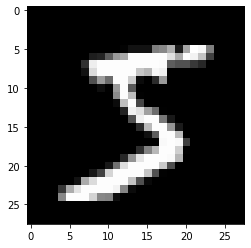

In [13]:
import matplotlib.pyplot as plt

with tf.device("CPU:0"):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print(
        "Predicted result is: %s, target result is: %s" % (result.numpy(), sample_label)
    )
    plt.imshow(sample, cmap=plt.get_cmap("gray"))

## RNNs with list/dict inputs, or nested inputs
## 采用列表/字典或者嵌套输入的RNN模型

Nested structures allow implementers to include more information within a single
timestep. For example, a video frame could have audio and video input at the same
time. The data shape in this case could be:

嵌套结构允许实施者在单个时间段内输入更多的信息，比如说，一个视频框架可以同时包含视频和音频输入。这样数据的形式就是

`[batch, timestep, {"video": [height, width, channel], "audio": [frequency]}]`

In another example, handwriting data could have both coordinates x and y for the
current position of the pen, as well as pressure information. So the data
representation could be:

另一个例子是，手写数据包含手写笔在X轴和Y轴上的位置信息和压力信息，所以这种数据会表示为

`[batch, timestep, {"location": [x, y], "pressure": [force]}]`

The following code provides an example of how to build a custom RNN cell that accepts
such structured inputs.

接下来的代码提供了一个关于五河建立自定义RNN cell来接受结构化输入的示例：

### Define a custom cell that supports nested input/output
### 自定义cell来支持嵌套输入/输出

See [Making new Layers & Models via subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models/)
for details on writing your own layers.

参考[通过子类来建立新层和新模型](https://www.tensorflow.org/guide/keras/custom_layers_and_models/) 来了解更多细节

In [14]:
class NestedCell(keras.layers.Layer):
    def __init__(self, unit_1, unit_2, unit_3, **kwargs):
        self.unit_1 = unit_1
        self.unit_2 = unit_2
        self.unit_3 = unit_3
        self.state_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        self.output_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        super(NestedCell, self).__init__(**kwargs)

    def build(self, input_shapes):
        # expect input_shape to contain 2 items, [(batch, i1), (batch, i2, i3)]
        i1 = input_shapes[0][1]
        i2 = input_shapes[1][1]
        i3 = input_shapes[1][2]

        self.kernel_1 = self.add_weight(
            shape=(i1, self.unit_1), initializer="uniform", name="kernel_1"
        )
        self.kernel_2_3 = self.add_weight(
            shape=(i2, i3, self.unit_2, self.unit_3),
            initializer="uniform",
            name="kernel_2_3",
        )

    def call(self, inputs, states):
        # inputs should be in [(batch, input_1), (batch, input_2, input_3)]
        # state should be in shape [(batch, unit_1), (batch, unit_2, unit_3)]
        input_1, input_2 = tf.nest.flatten(inputs)
        s1, s2 = states

        output_1 = tf.matmul(input_1, self.kernel_1)
        output_2_3 = tf.einsum("bij,ijkl->bkl", input_2, self.kernel_2_3)
        state_1 = s1 + output_1
        state_2_3 = s2 + output_2_3

        output = (output_1, output_2_3)
        new_states = (state_1, state_2_3)

        return output, new_states

    def get_config(self):
        return {"unit_1": self.unit_1, "unit_2": unit_2, "unit_3": self.unit_3}


### Build a RNN model with nested input/output
### 建立一个使用嵌套输入/输出的RNN模型

Let's build a Keras model that uses a `keras.layers.RNN` layer and the custom cell
we just defined.

让我们用`keras.layers.RNN`来建立一个Keras模型并自定义我们所定义的cell

In [15]:
unit_1 = 10
unit_2 = 20
unit_3 = 30

i1 = 32
i2 = 64
i3 = 32
batch_size = 64
num_batches = 10
timestep = 50

cell = NestedCell(unit_1, unit_2, unit_3)
rnn = keras.layers.RNN(cell)

input_1 = keras.Input((None, i1))
input_2 = keras.Input((None, i2, i3))

outputs = rnn((input_1, input_2))

model = keras.models.Model([input_1, input_2], outputs)

model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

### Train the model with randomly generated data
### 用随机生成的数据来训练这个模型

Since there isn't a good candidate dataset for this model, we use random Numpy data for
demonstration.

由于这个模型没有好的候选数据集，所以我们用随机numpy数据来进行演示

In [16]:
input_1_data = np.random.random((batch_size * num_batches, timestep, i1))
input_2_data = np.random.random((batch_size * num_batches, timestep, i2, i3))
target_1_data = np.random.random((batch_size * num_batches, unit_1))
target_2_data = np.random.random((batch_size * num_batches, unit_2, unit_3))
input_data = [input_1_data, input_2_data]
target_data = [target_1_data, target_2_data]

model.fit(input_data, target_data, batch_size=batch_size)

10/10 [==============================] - 1s 25ms/step - loss: 0.9178 - rnn_1_loss: 0.3211 - rnn_1_1_loss: 0.5968 - rnn_1_accuracy: 0.1097 - rnn_1_1_accuracy: 0.0382


With the Keras `keras.layers.RNN` layer, You are only expected to define the math
logic for individual step within the sequence, and the `keras.layers.RNN` layer
will handle the sequence iteration for you. It's an incredibly powerful way to quickly
prototype new kinds of RNNs (e.g. a LSTM variant).

For more details, please visit the [API docs](https://https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN/).

使用`keras.layers.RNN`层，你只需要为序列中的各个步骤定义数据逻辑。同时，`keras.layers.RNN`层还可以为了管控序列迭代。 这是一种快速建立新的RNN原型的强大方式

更多细节，请访问[API 文档](https://https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN/).